In [87]:
### calculate distance between two points
def cal_distance(lat1, lon1):
    from math import sin, cos, sqrt, atan2, radians # calculate distance between two GPS coordinates
    import warnings
    import csv
    import pandas as pd
    # approximate radius of earth in km
    R = 3956
    with open('chicago_zip_geo.csv', mode='r') as f:
        reader = csv.reader(f)
        temp=[]
        df=pd.DataFrame([[ij for ij in i] for i in reader])
        temp=df.values.tolist()
        loc_zip_dis=[]
        for item in temp:
            lat2 = float(item[1])
            lon2 = float(item[2])
            dlon = radians(lon1 - lon2)
            dlat = radians(lat1 - lat2)
            a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            loc_zip_dis.append([item[0],distance])
        loc_zip_dis.sort(key=lambda x: x[1])
        return loc_zip_dis[0]



### add the nearest zip code to every crime location
import pandas as pd
data = pd.read_csv("crime2001to2018.csv")
df = pd.DataFrame(data)
row_count=df.shape[0]
zip_for_loc=[]
dist_to_zip=[]
primary_type=[]
description=[]
year=[]
latitude=[]
longitude=[]
location=[]
new_df=pd.DataFrame()

for n in range(0,row_count):
    try:
        lat1 = df.iloc[n,5]
        lon1 = df.iloc[n,6]
        dist = cal_distance(float(lat1), float(lon1))
        primary_type.append(df.iloc[n,2])
        description.append(df.iloc[n,3])
        year.append(df.iloc[n,4])
        latitude.append(df.iloc[n,5])
        longitude.append(df.iloc[n,6])
        location.append(df.iloc[n,7])
        zip_for_loc.append(dist[0])
        dist_to_zip.append(dist[1])
    except: 
        pass
new_df = new_df.assign(primary_type = primary_type, description = description, year = year, latitude = latitude, longitude = longitude, location = location, zip_code = zip_for_loc, dist_to_zip = dist_to_zip)

new_df.to_csv('crime_all_with_zip_new.csv', encoding='utf-8', index=False)



In [91]:
import pandas as pd
data = pd.read_csv("crime_all_with_zip_new.csv")
df = pd.DataFrame(data)
df.head(2)

,primary_type,description,year,latitude,longitude,location,zip_code,dist_to_zip
0,BATTERY,AGGRAVATED: HANDGUN,2015,41.891399,-87.744385,"(41.891398861, -87.744384567)",60651,0.760310
1,OTHER OFFENSE,PAROLE VIOLATION,2015,41.773372,-87.665319,"(41.773371528, -87.665319468)",60636,0.252779


In [75]:
import pandas as pd
data = pd.read_csv('crime_2017_with_zip_new.csv')
df = pd.DataFrame(data)
df.head(5)

,primary_type,description,year,latitude,longitude,location,zip_code,dist_to_zip
0,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,2017,42.012293,-87.699714,"(42.012293397, -87.699714109)",60645,0.362998
1,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,2017,41.918712,-87.765511,"(41.918711651, -87.76551063)",60639,0.502180
2,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,2017,41.814670,-87.690727,"(41.814669784, -87.690726696)",60632,1.200173
3,DECEPTIVE PRACTICE,BOGUS CHECK,2017,41.938581,-87.765831,"(41.938581442, -87.765830579)",60641,1.124055
4,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER,2017,41.895805,-87.683159,"(41.895805099, -87.683159355)",60622,0.439699


(65478, 9)

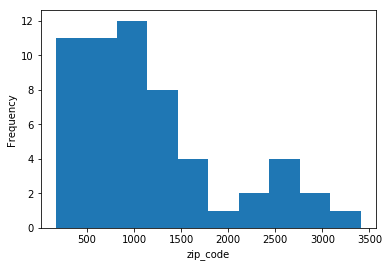

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
fig = plt.figure() 
ax = fig.add_subplot(1, 1, 1)
df = pd.read_csv('crime_2017_with_zip.csv')
ax.hist(df.groupby('zip_code')['Primary Type'].count())
ax.set_ylabel('Frequency')
ax.set_xlabel('zip_code')
df.shape



In [4]:
import pandas as pd
data = pd.read_csv("crime2017.csv")
data.shape

(65478, 7)

In [11]:
import pandas as pd
df = pd.read_csv('crime_2017_with_zip.csv')
df.head()
len(df)

65478

Text(0.5, 1.0, 'Crime and Traffic Violation Geo Mapping')

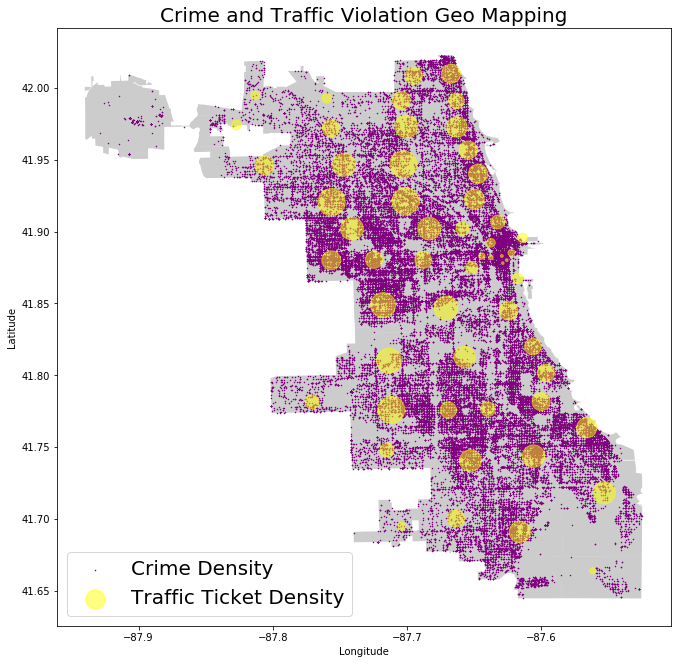

In [15]:
### Create geo mapping with traffic ticket data and crime data
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

street_map = gpd.read_file('geo_export_a0ce5bcd-6f38-4be5-b31d-86347ad14ed1.shp')
### may need to fix the shp file by $ SHAPE_RESTORE_SHX=YES fio info myshapefile.shp

df = pd.read_csv ('crime_2017_with_zip.csv')
df1 = pd.read_csv('zip_geo_merge_freq.csv')

crs = {'init':'epsg:4326'}

geometry = [Point(xy) for xy in zip (df["Longitude"],df["Latitude"])]
geometry1 = [Point(xy) for xy in zip (df1["Lon"],df1["Lat"])]
geometry[0:3]
geometry1[0:3]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df1 = gpd.GeoDataFrame(df1, crs = crs, geometry = geometry1)


fig, ax = plt.subplots(figsize = (11,11))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['Year']==2017].plot(ax=ax, markersize = 0.4, color = 'purple', marker = '*', label = 'Crime Density')
geo_df1[geo_df1['Year']==2017].plot(ax=ax, markersize = geo_df1['violation_freq']/50, 
                        color = 'yellow', alpha=0.5, marker = "o", label = 'Traffic Ticket Density')
plt.legend(prop={'size':20})
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Crime and Traffic Violation Geo Mapping',fontsize=20)





In [103]:
#create a new violation2017 file with zipcode cleaned up
import pandas as pd
df = pd.read_csv('violation2017.csv')
df = df[pd.to_numeric(df['zipcode'], errors='coerce').notnull()]
df['zipcode'] = df['zipcode'].str[:5]
df = df.dropna(subset=['zipcode'])
df.to_csv('violation2017_clean_zip.csv', encoding='utf-8', index=False)

#df = pd.DataFrame('zipcode', dtype='int')
#df = df[(df['zipcode'] >= 60601) & (df['zipcode'] <= 60661)]





In [117]:
#create zip_geo_merge file with traffic violation frequency
import pandas as pd
df = pd.read_csv('violation2017_clean_zip.csv')
df_zip = pd.read_csv('chicago_zip_geo.csv')
s = df['zipcode']
df['zipcode'] = pd.to_numeric(s,downcast = 'integer')
df = df[(df['zipcode'] >= 60601) & (df['zipcode'] <= 60661)]
dff = pd.DataFrame(df.groupby('zipcode')['violation_description'].count())

zip_geo_merge = pd.merge(dff, df_zip, on=['zipcode'], how='outer')
zip_geo_merge.to_csv('zip_geo_merge_freq.csv',encoding='utf-8', index=False)



In [142]:
#create zip_geo_merge2 file with crime frequency 
import pandas as pd
df_crime = pd.read_csv('crime_2017_with_zip.csv')
df_crime.rename(columns = {'zip_code': 'zipcode'}, inplace = True)
df_crime_2 = pd.DataFrame(df_crime.groupby('zipcode')['Primary Type'].count())

df_traffic = pd.read_csv('zip_geo_merge_freq.csv')
zip_geo_merge2 = pd.merge(df_traffic, df_crime_2, on=['zipcode'], how = 'inner')
zip_geo_merge2.to_csv('zip_geo_merge_trcl_freq.csv', encoding = 'utf-8', index = False)

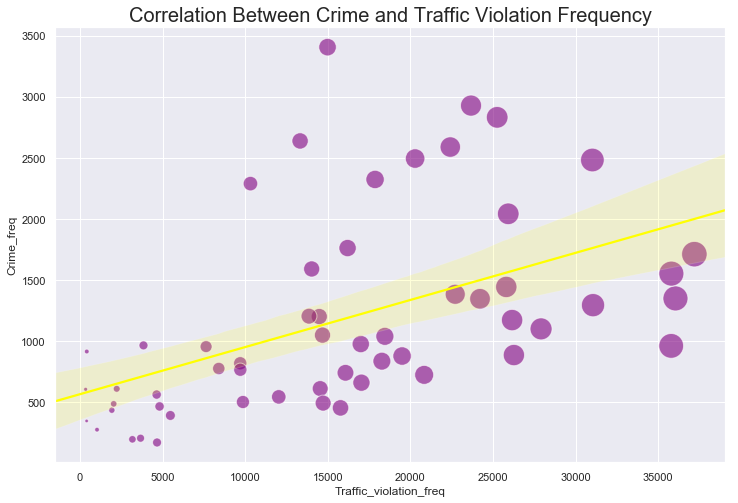

In [93]:
#create regression plot for traffic violation and crime.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes = True)
df = pd.read_csv('zip_geo_merge_trcl_freq.csv')
df.rename(columns = {'violation_freq':'Traffic_violation_freq'}, inplace = True)
df.rename(columns = {'Primary Type':'Crime_freq'}, inplace=True)
sns.regplot(x=df["Traffic_violation_freq"], y=df["Crime_freq"], 
            color='purple', scatter_kws={"s": (df["Crime_freq"]
                +df["Traffic_violation_freq"])/2/30,"alpha":0.6, 'edgecolor':'w'}, line_kws={'color':'yellow'}).set_title(
                    'Correlation Between Crime and Traffic Violation Frequency', fontsize=20)
sns.set(rc={'figure.figsize':(12,8)})


In [13]:
import pandas as pd
pd = pd.read_csv('crime2017-full.csv')
pd['Latitude'].count()

264997

In [152]:
import pandas as pd
data = pd.read_csv('crime_2017_with_zip_new.csv')
df = pd.DataFrame(data)
df.head(5)

,primary_type,description,year,latitude,longitude,location,zip_code,dist_to_zip
0,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,2017,42.012293,-87.699714,"(42.012293397, -87.699714109)",60645,0.362998
1,CRIMINAL DAMAGE,TO CITY OF CHICAGO PROPERTY,2017,41.918712,-87.765511,"(41.918711651, -87.76551063)",60639,0.502180
2,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,2017,41.814670,-87.690727,"(41.814669784, -87.690726696)",60632,1.200173
3,DECEPTIVE PRACTICE,BOGUS CHECK,2017,41.938581,-87.765831,"(41.938581442, -87.765830579)",60641,1.124055
4,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER,2017,41.895805,-87.683159,"(41.895805099, -87.683159355)",60622,0.439699


In [153]:
import pandas as pd
crime2017 = pd.read_csv('crime_2017_with_zip_new.csv')
by_zip = crime2017.groupby('zip_code')

In [154]:
crime2017.zip_code.unique()

array([60645, 60639, 60632, 60641, 60622, 60621, 60628, 60623, 60601,
       60620, 60643, 60644, 60624, 60619, 60618, 60647, 60649, 60614,
       60602, 60625, 60611, 60637, 60652, 60653, 60661, 60608, 60609,
       60629, 60634, 60636, 60615, 60646, 60607, 60617, 60630, 60612,
       60660, 60654, 60640, 60659, 60655, 60606, 60657, 60610, 60651,
       60613, 60633, 60642, 60604, 60603, 60626, 60616, 60638, 60631,
       60656, 60605])

In [155]:
sample = by_zip.get_group(60645)
sample.head()

,primary_type,description,year,latitude,longitude,location,zip_code,dist_to_zip
0,DECEPTIVE PRACTICE,COUNTERFEIT CHECK,2017,42.012293,-87.699714,"(42.012293397, -87.699714109)",60645,0.362998
271,BATTERY,DOMESTIC BATTERY SIMPLE,2017,42.015655,-87.689425,"(42.015655391, -87.689424909)",60645,0.560668
354,OTHER OFFENSE,HARASSMENT BY TELEPHONE,2017,41.997823,-87.684348,"(41.997822516, -87.684347635)",60645,0.912945
427,THEFT,$500 AND UNDER,2017,42.000290,-87.681438,"(42.000289522, -87.681438236)",60645,0.889576
594,CRIMINAL DAMAGE,TO PROPERTY,2017,42.018245,-87.690186,"(42.018244679, -87.690186314)",60645,0.708357


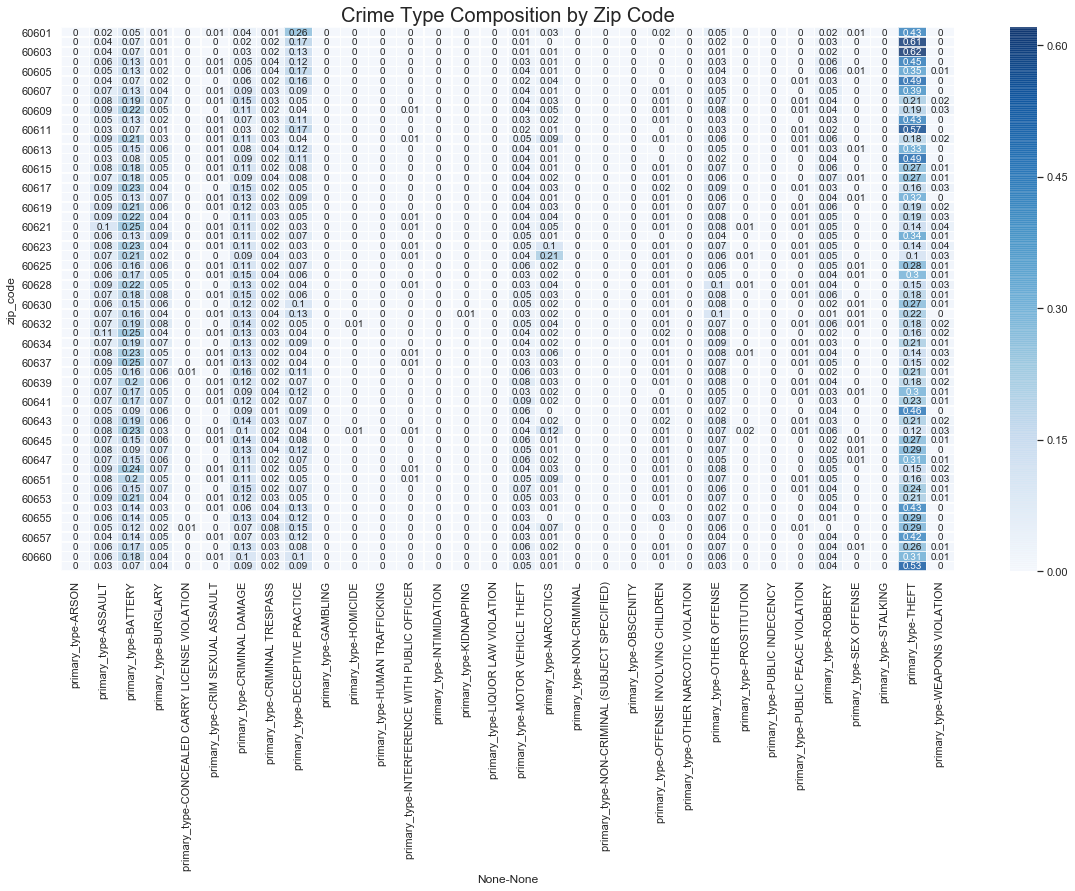

In [157]:
#heat map for crime type by zip code
def type_detail(group):
    return pd.DataFrame(group.primary_type.value_counts(normalize = True)).round(2)

type_by_zip = by_zip.apply(type_detail).unstack().fillna(0)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10)) 
plt.title('Crime Type Composition by Zip Code',size = 20)
sns.heatmap(type_by_zip, annot = True, cmap = 'Blues', alpha = 0.8,linewidths=.5)

In [158]:
import pandas as pd
data = pd.read_csv('violation2017_clean_zip.csv')
df = pd.DataFrame(data)
df.zipcode = df.zipcode.astype(int)
df.head(5)

,Unnamed: 0,issue_date,violation_code,violation_description,zipcode,fine_level1_amount,fine_level2_amount,year
0,25443670,2017-01-23 09:20:00,0964110F,PARK OR STAND ON BRIDGE,60629,75,150,2017
1,25443674,2017-01-23 09:20:00,0976160F,EXPIRED PLATES OR TEMPORARY REGISTRATION,60154,60,120,2017
2,25443675,2017-01-23 09:20:00,0976160D,NONCOMPLIANT PLATE(S),60645,60,120,2017
3,25443676,2017-01-23 09:20:00,0964190A,EXP. METER NON-CENTRAL BUSINESS DISTRICT,60625,50,100,2017
4,25443677,2017-01-23 09:20:00,0964080B,NO STANDING/PARKING TIME RESTRICTED,60659,100,200,2017


In [164]:
import pandas as pd
traffic2017 = pd.read_csv('violation2017_clean_zip.csv')
traffic2017.zipcode = traffic2017.zipcode.astype(int)
by_zip = traffic2017.groupby('zipcode')
print('Total different types of traffic viloation: ', len(traffic2017.violation_description.unique()))
print()
print(traffic2017.violation_description.unique())

Total different types of traffic viloation:  114

['PARK OR STAND ON BRIDGE' 'EXPIRED PLATES OR TEMPORARY REGISTRATION'
 'NONCOMPLIANT PLATE(S)' 'EXP. METER NON-CENTRAL BUSINESS DISTRICT'
 'NO STANDING/PARKING TIME RESTRICTED' 'RESIDENTIAL PERMIT PARKING'
 'REAR AND FRONT PLATE REQUIRED' 'EXPIRED METER CENTRAL BUSINESS DISTRICT'
 'PARK OR STAND IN BUS/TAXI/CARRIAGE STAND'
 'NO CITY STICKER VEHICLE UNDER/EQUAL TO 16,000 LBS.' 'OBSTRUCT ROADWAY'
 "WRONG DIRECTION OR 12'' FROM CURB" 'CURB LOADING ZONE'
 'PARKING/STANDING PROHIBITED ANYTIME'
 'TRUCK,RV,BUS, OR TAXI RESIDENTIAL STREET' 'INDUSTRIAL PERMIT PARKING'
 'IMPROPER DISPLAY OF CITY STICKER' "WITHIN 15' OF FIRE HYDRANT"
 "20'OF CROSSWALK" 'PARK OR STAND ON CROSSWALK'
 'STOP SIGN OR TRAFFIC SIGNAL' 'BLOCK ACCESS/ALLEY/DRIVEWAY/FIRELANE'
 'DISABLED PARKING ZONE' 'PARK OR STAND ON SIDEWALK'
 'PARKED/STANDING UNATTENDED W/MOTOR RUNNI'
 'PARK OR STAND ON CITY PROPERTY' 'HAZARDOUS DILAPIDATED VEHICLE'
 'ABANDONED VEH. FOR 7 DAYS OR INOPERA

In [33]:
#use geopandas and bokeh to create interactive map. 
import geopandas as gpd
from bokeh.plotting import save, figure
from bokeh.models import GeoJSONDataSource

street_map = gpd.read_file('geo_export_a0ce5bcd-6f38-4be5-b31d-86347ad14ed1.shp')
### may need to fix the shp file by $ SHAPE_RESTORE_SHX=YES fio info myshapefile.shp
df = pd.read_csv ('crime_2017_with_zip.csv')
df1 = pd.read_csv('zip_geo_merge_freq.csv')
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip (df["Longitude"],df["Latitude"])]
geometry1 = [Point(xy) for xy in zip (df1["Lon"],df1["Lat"])]
geometry[0:3]
geometry1[0:3]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df1 = gpd.GeoDataFrame(df1, crs = crs, geometry = geometry1)


# Convert GeoDataFrames into GeoJSONDataSource objects (similar to ColumnDataSource)
point_source = GeoJSONDataSource(geojson=geo_df.to_json())
point_source1 = GeoJSONDataSource(geojson=geo_df1.to_json())
roads_source = GeoJSONDataSource(geojson=street_map.to_json())

# Initialize our plot figure
p = figure(title="Crime Occurance Interactive Map")

# Add the lines to the map from our GeoJSONDataSource -object (it is important to specify the columns as 'xs' and 'ys')
p.multi_line('xs', 'ys', source=roads_source, color='gray', line_width=1)

# add circles (points)
p.circle('x', 'y', source=point_source, color='purple', size=0.1)
#p.circle('x', 'y', source=point_source1, color='yellow', size=1, alpha = 0.6)
outfp = "test_map.html"

# Save the map
save(p, outfp)

'/Users/eddiezhu/assignments_upstream_fall18/SUBMISSIONS/project_2/test_map.html'

In [107]:
#use geopandas and bokeh to create interactive map. 
import geopandas as gpd
from bokeh.plotting import save, figure, show, gridplot
from bokeh.models import GeoJSONDataSource, Legend, LegendItem

street_map = gpd.read_file('geo_export_a0ce5bcd-6f38-4be5-b31d-86347ad14ed1.shp')
### may need to fix the shp file by $ SHAPE_RESTORE_SHX=YES fio info myshapefile.shp
df = pd.read_csv ('crime_2017_with_zip.csv')
df1 = pd.read_csv('zip_geo_merge_trcl_freq.csv')
df2 = pd.read_csv('zip_geo_merge_demographic.csv')

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip (df["Longitude"],df["Latitude"])]
geometry1 = [Point(xy) for xy in zip (df1["Lon"],df1["Lat"])]
geometry2 = [Point(xy) for xy in zip (df2["Lon"], df2["Lat"])]
geometry[0:3]
geometry1[0:3]
geometry2[0:3]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df1 = gpd.GeoDataFrame(df1, crs = crs, geometry = geometry1)
geo_df2 = gpd.GeoDataFrame(df2, crs = crs, geometry = geometry2)


# Convert GeoDataFrames into GeoJSONDataSource objects (similar to ColumnDataSource)
point_source = GeoJSONDataSource(geojson=geo_df.to_json())
point_source1 = GeoJSONDataSource(geojson=geo_df1.to_json())
point_source2 = GeoJSONDataSource(geojson=geo_df2.to_json())

map_source = GeoJSONDataSource(geojson=street_map.to_json())
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
sizes = geo_df1['violation_freq']/5000000
sizes2 = geo_df2['Population Density (#/sqr mile)']/5000000

# Initialize our plot figure
p = figure(title="Crime/Traffic Violation Occurance Interactive Map with Population Density",tools= TOOLS)
p.toolbar.logo = None
# Add the lines to the map from our GeoJSONDataSource -object (it is important to specify the columns as 'xs' and 'ys')
p.multi_line('xs', 'ys', source=map_source, color='gray', line_width=1)
f1=p.multi_line('xs', 'ys', source=map_source, color='gray', line_width=1)

# add circles (points)
p.circle('x', 'y', source=point_source, color='purple', size=0.15)
f2=p.circle('x', 'y', source=point_source, color='purple', size=0.15)
p.circle(x = geo_df1['Lon'], y = geo_df1['Lat'], radius = sizes, color = 'blue',alpha = 0.6)
f3=p.circle(x = geo_df1['Lon'], y = geo_df1['Lat'], radius = sizes, color = 'blue',alpha = 0.6)
p.circle(x=geo_df2['Lon'], y = geo_df2['Lat'], radius = sizes2, color = 'orange', alpha = 0.3)
f4=p.circle(x=geo_df2['Lon'], y = geo_df2['Lat'], radius = sizes2, color = 'orange', alpha = 0.3)


legend = Legend(items=[
    LegendItem(label="Crime Occurance", renderers=[f2], index=0),
    LegendItem(label="Traffic Violation Freq", renderers=[f3], index=1),
    LegendItem(label="Population Density", renderers=[f4], index=2)
])
p.add_layout(legend)
p.legend.location = "bottom_left"
#show(p)
outfp = "map_crime_violation_demo.html"
#Save the map
save(p, outfp)

'/Users/eddiezhu/assignments_upstream_fall18/SUBMISSIONS/project_2/map_crime_violation_demo.html'

In [87]:
#create zip_geo_merge file for demographic
import pandas as pd
df = pd.read_csv('zipcode_demographics.csv')
df.rename(columns = {'zip code': 'zipcode'}, inplace = True)
df = df[(df['zipcode'] >= 60601) & (df['zipcode'] <= 60661)]
df_zip = pd.read_csv('chicago_zip_geo_with_head.csv')
df_zip.rename(columns = {'Zipcode':'zipcode'}, inplace = True)
s = df['zipcode']
df['zipcode'] = pd.to_numeric(s,downcast = 'integer')

zip_geo_merge = pd.merge(df, df_zip, on=['zipcode'], how='outer')
zip_geo_merge.to_csv('zip_geo_merge_demographic.csv',encoding='utf-8', index=False)

In [93]:
import pandas as pd
df_zip = pd.read_csv('zip_geo_merge_freq.csv')
df_zip

,zipcode,violation_freq,Lat,Lon,Year
0,60601,2226,41.885310,-87.622116,2017
1,60602,414,41.883073,-87.629149,2017
2,60603,407,41.880188,-87.625509,2017
3,60604,346,41.878095,-87.628461,2017
4,60605,5475,41.867566,-87.617228,2017
5,60606,1035,41.882066,-87.637349,2017
6,60607,7635,41.874930,-87.651596,2017
7,60608,27907,41.846880,-87.670664,2017
8,60609,22713,41.812680,-87.656935,2017
9,60610,9701,41.906772,-87.632231,2017
